In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, BatchNorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from torch_geometric.explain import Explainer, GNNExplainer
from sklearn.model_selection import KFold


/leonardo/prod/opt/libraries/cineca-ai/4.3.0/none/cineca-ai-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/leonardo/prod/opt/libraries/cineca-ai/4.3.0/none/cineca-ai-env/lib/python3.11/site-packages/transformers/utils/generic.py:462: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
# =============================================================================
# PARAMETRI DI CLUSTERING
# =============================================================================
CLUSTER_PARAMS = dict(
    charge_threshold=750,
    min_consecutive_strips=2,
    max_gap=2,
    max_cluster_size=15,
    max_internal_gap=2
)


In [3]:

# =============================================================================
# FUNZIONI DI CLUSTERING
# =============================================================================

def cluster_strips_with_charges(event, params):
    """Identifica cluster consecutivi di strip con carica sopra soglia."""
    clusters = []
    charges = []
    current_cluster = []
    current_charges = []
    previous_index = None

    for strip_index, charge in enumerate(event):
        if charge >= params['charge_threshold']:
            if previous_index is not None and strip_index - previous_index - 1 >= params['max_gap']:
                if params['min_consecutive_strips'] <= len(current_cluster) < params['max_cluster_size']:
                    n_gaps = (max(current_cluster) - min(current_cluster) + 1) - len(current_cluster)
                    if n_gaps <= params['max_internal_gap']:
                        clusters.append(current_cluster)
                        charges.append(current_charges)
                current_cluster, current_charges = [], []
            current_cluster.append(strip_index)
            current_charges.append(charge)
            previous_index = strip_index

    # Aggiungi ultimo cluster se valido
    if params['min_consecutive_strips'] <= len(current_cluster) < params['max_cluster_size']:
        n_gaps = (max(current_cluster) - min(current_cluster) + 1) - len(current_cluster)
        if n_gaps <= params['max_internal_gap']:
            clusters.append(current_cluster)
            charges.append(current_charges)

    return clusters, charges

def assign_labels(event, params):
    """Assegna etichetta 1 alle strip che fanno parte di un cluster valido."""
    labels = np.zeros(len(event), dtype=int)
    clusters, _ = cluster_strips_with_charges(event, params)
    for cluster in clusters:
        for idx in range(min(cluster), max(cluster) + 1):
            labels[idx] = 1
    return labels, len(clusters)


In [4]:

# =============================================================================
# CARICAMENTO DATI E LABELING
# =============================================================================

x_events = np.load('data/mimega/signal_x.npy', allow_pickle=True)
y_events = np.load('data/mimega/signal_y.npy', allow_pickle=True)

x_labels, y_labels = [], []
n_x_clusters = n_y_clusters = 0

for x_ev, y_ev in zip(x_events, y_events):
    x_lab, n_x = assign_labels(x_ev, CLUSTER_PARAMS)
    y_lab, n_y = assign_labels(y_ev, CLUSTER_PARAMS)
    x_labels.append(x_lab)
    y_labels.append(y_lab)
    n_x_clusters += n_x
    n_y_clusters += n_y

print(f"Numero di cluster trovati in X: {n_x_clusters}")
print(f"Numero di cluster trovati in Y: {n_y_clusters}")


Numero di cluster trovati in X: 908
Numero di cluster trovati in Y: 3047


In [5]:

# =============================================================================
# CREAZIONE DEI GRAFICI
# =============================================================================

def events_to_graphs(events, labels, max_charge=1000.0):
    """Trasforma eventi e label in grafi PyG per la GNN."""
    data_list = []
    for event, label in zip(events, labels):
        event = np.array(event, dtype=np.float32)
        label = np.array(label, dtype=np.int64)
        
        # Normalizzazione rispetto al massimo calcolato
        event = np.clip(event, 0, max_charge) / max_charge

        x = torch.tensor(event, dtype=torch.float).unsqueeze(1)
        y = torch.tensor(label, dtype=torch.long)
        
        N = x.shape[0]
        edge_index = torch.tensor(
            [[i, i+1] for i in range(N-1)] + [[i+1, i] for i in range(N-1)],
            dtype=torch.long
        ).t().contiguous()
        
        data_list.append(Data(x=x, edge_index=edge_index, y=y))
    return data_list

# Split train/val/test
all_events = np.concatenate([x_events, y_events])
all_labels = np.concatenate([x_labels, y_labels])
all_data = list(zip(all_events, all_labels))

train_data, temp_data = train_test_split(all_data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

train_events, train_labels = zip(*train_data)
val_events, val_labels = zip(*val_data)
test_events, test_labels = zip(*test_data)

# Estrai carica massima dal train set
train_max_charge = max(np.max(event) for event in train_events)
print(f"Massima carica trovata nel train set: {train_max_charge}")

# Creazione dei grafi con normalizzazione rispetto al massimo del train set
train_graphs = events_to_graphs(train_events, train_labels, max_charge=train_max_charge)
val_graphs = events_to_graphs(val_events, val_labels, max_charge=train_max_charge)
test_graphs = events_to_graphs(test_events, test_labels, max_charge=train_max_charge)


train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32)
test_loader = DataLoader(test_graphs, batch_size=32)


Massima carica trovata nel train set: 2089.0


In [6]:

# =============================================================================
# DEFINIZIONE MODELLO GNN
# =============================================================================

class GNN(nn.Module):
    def __init__(self, in_channels=4, hidden_channels=64, out_channels=1, num_layers=3, dropout=0.2):
        super().__init__()
        self.pre_mlp = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU()
        )
        self.convs = nn.ModuleList([GCNConv(hidden_channels, hidden_channels) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
        self.post_mlp = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.pre_mlp(x)
        for conv in self.convs:
            x_res = x
            x = F.relu(conv(x, edge_index))
            x = self.dropout(x)
            x = x + x_res 
        x = self.post_mlp(x)
        return x.view(-1)

In [7]:

# =============================================================================
# INIZIALIZZAZIONE E LOSS
# =============================================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = GNN(in_channels=1, hidden_channels=32, out_channels=1, num_layers=4, dropout=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

pos_weight = torch.tensor([5], dtype=torch.float32).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)


Using device: cuda


In [8]:

# =============================================================================
# SALVATAGGIO E CARICAMENTO MODELLO
# =============================================================================

def save_checkpoint(model, optimizer, epoch, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)

def save_model(model, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)
    print(f"Modello finale salvato in {path}")

def load_model(model, optimizer, checkpoint_path, load_checkpoint=True):
    if load_checkpoint and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        if optimizer and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint.get('epoch', 0) + 1
        print(f"Checkpoint caricato da {checkpoint_path}, riprendo da epoch {start_epoch}")
    else:
        print("Nessun checkpoint caricato.")
        start_epoch = 0
    return model, optimizer, start_epoch

checkpoint_path = "gnn_model/mimega/checkpoint.pt"
model_path = "gnn_model/mimega/model.pt"
model, optimizer, start_epoch = load_model(model, optimizer, checkpoint_path, load_checkpoint=True)


Nessun checkpoint caricato.


In [9]:

# =============================================================================
# TRAINING
# =============================================================================

epochs = 20
for epoch in range(start_epoch, epochs):
    start = time.time()
    model.train()
    total_loss = 0
    total_samples = 0
    for batch in train_loader:
        batch = batch.to(device)
        output = model(batch).squeeze(-1)
        loss = loss_fn(output, batch.y.float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item() * batch.y.size(0)
        total_samples += batch.y.size(0)
    train_loss = total_loss / total_samples

    model.eval()
    val_loss, val_samples = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            output = model(batch).squeeze(-1)
            loss = loss_fn(output, batch.y.float())
            val_loss += loss.item() * batch.y.size(0)
            val_samples += batch.y.size(0)
    val_loss /= val_samples

    print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f} - Validation loss: {val_loss:.4f} - Time: {time.time()-start:.2f}s")
    save_checkpoint(model, optimizer, epoch, checkpoint_path)


print("Training completo.")
save_model(model, model_path)

Epoch 1/20 - Train loss: 0.0538 - Validation loss: 0.0043 - Time: 2.98s
Epoch 2/20 - Train loss: 0.0069 - Validation loss: 0.0036 - Time: 1.81s
Epoch 3/20 - Train loss: 0.0061 - Validation loss: 0.0035 - Time: 1.80s
Epoch 4/20 - Train loss: 0.0055 - Validation loss: 0.0035 - Time: 1.80s
Epoch 5/20 - Train loss: 0.0050 - Validation loss: 0.0027 - Time: 1.80s
Epoch 6/20 - Train loss: 0.0048 - Validation loss: 0.0028 - Time: 1.80s
Epoch 7/20 - Train loss: 0.0044 - Validation loss: 0.0024 - Time: 1.80s
Epoch 8/20 - Train loss: 0.0040 - Validation loss: 0.0023 - Time: 1.80s
Epoch 9/20 - Train loss: 0.0041 - Validation loss: 0.0026 - Time: 1.81s
Epoch 10/20 - Train loss: 0.0039 - Validation loss: 0.0021 - Time: 1.80s
Epoch 11/20 - Train loss: 0.0038 - Validation loss: 0.0026 - Time: 1.82s
Epoch 12/20 - Train loss: 0.0036 - Validation loss: 0.0024 - Time: 1.80s
Epoch 13/20 - Train loss: 0.0035 - Validation loss: 0.0018 - Time: 1.80s
Epoch 14/20 - Train loss: 0.0035 - Validation loss: 0.0018 -

In [10]:
# =============================================================================
# Bootstrap per la valutazione del modello
# =============================================================================

def get_all_preds_labels(model, loader, device):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = torch.sigmoid(model(data))
            all_probs.append(out.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    return all_probs, all_labels

def bootstrap_metrics(y_true, y_prob, n_bootstrap=1000, threshold=0.5, random_state=42):
    rng = np.random.RandomState(random_state)
    n = len(y_true)
    accs, precs, recs, f1s = [], [], [], []
    for _ in range(n_bootstrap):
        idx = rng.choice(n, n, replace=True)
        y_true_bs = y_true[idx]
        y_prob_bs = y_prob[idx]
        y_pred_bs = (y_prob_bs > threshold).astype(int)
        accs.append(accuracy_score(y_true_bs, y_pred_bs))
        precs.append(precision_score(y_true_bs, y_pred_bs, zero_division=0))
        recs.append(recall_score(y_true_bs, y_pred_bs, zero_division=0))
        f1s.append(f1_score(y_true_bs, y_pred_bs, zero_division=0))
    return {
        'acc': np.array(accs),
        'prec': np.array(precs),
        'rec': np.array(recs),
        'f1': np.array(f1s)
    }

# Ottieni tutte le probabilità e label del test set
all_probs, all_labels = get_all_preds_labels(model, test_loader, device)

# Bootstrap
results = bootstrap_metrics(all_labels, all_probs, n_bootstrap=100)

# Calcola media e intervallo di confidenza al 95%
for metric in ['acc', 'prec', 'rec', 'f1']:
    mean = np.mean(results[metric])
    std = np.std(results[metric])
    ci_low = np.percentile(results[metric], 2.5)
    ci_high = np.percentile(results[metric], 97.5)
    print(f"{metric.upper()}: {mean:.5f} ± {std:.5f} (95% CI: {ci_low:.4f} - {ci_high:.4f})")

ACC: 0.99928 ± 0.00003 (95% CI: 0.9992 - 0.9994)
PREC: 0.81991 ± 0.00805 (95% CI: 0.8055 - 0.8408)
REC: 0.99491 ± 0.00153 (95% CI: 0.9915 - 0.9973)
F1: 0.89895 ± 0.00499 (95% CI: 0.8905 - 0.9113)


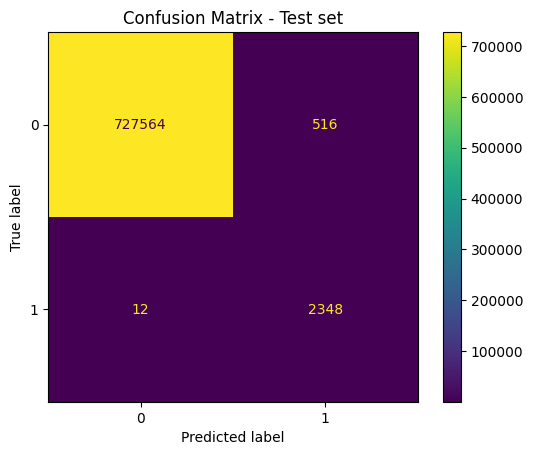

In [11]:
# =============================================================================
#  Confusion Matrix 
# =============================================================================

# Ottieni predizioni e label su tutto il test set
all_preds = []
all_labels = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = torch.sigmoid(model(data))
        preds = (out > 0.5).long().cpu().numpy()
        labels = data.y.cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - Test set")
plt.show()

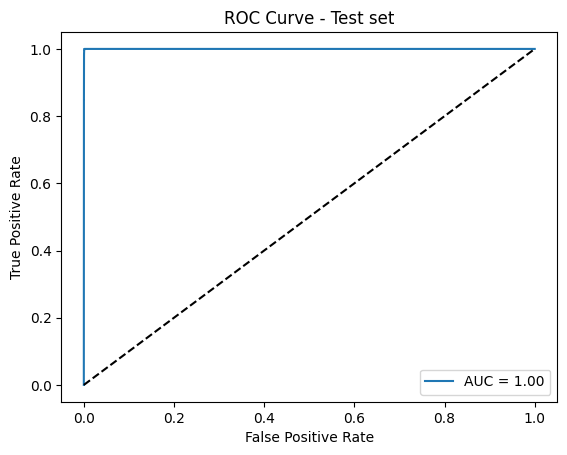

In [12]:
# =============================================================================
#  ROC Curve e AUC 
# =============================================================================

all_probs = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = torch.sigmoid(model(data))
        all_probs.append(out.cpu().numpy())
all_probs = np.concatenate(all_probs)

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test set')
plt.legend()
plt.show()

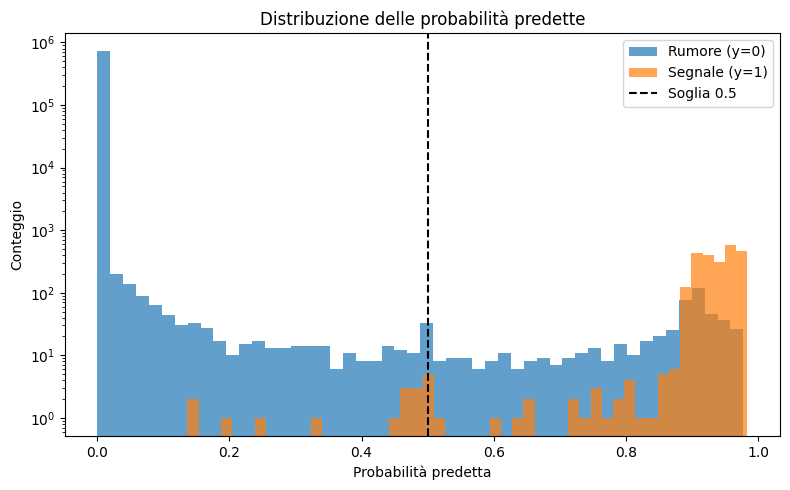

In [13]:
# =============================================================================
# Istogramma delle probabilità 
# =============================================================================

all_probs = []
all_labels = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = torch.sigmoid(model(data))
        all_probs.append(out.cpu().numpy())
        all_labels.append(data.y.cpu().numpy())
all_probs = np.concatenate(all_probs)
all_labels = np.concatenate(all_labels)

plt.figure(figsize=(8,5))
bins = 50
plt.hist(all_probs[all_labels == 0], bins=bins, alpha=0.7, label='Rumore (y=0)')
plt.hist(all_probs[all_labels == 1], bins=bins, alpha=0.7, label='Segnale (y=1)')
plt.axvline(0.5, color='k', linestyle='--', label='Soglia 0.5')
plt.xlabel('Probabilità predetta')
plt.ylabel('Conteggio')
plt.title('Distribuzione delle probabilità predette')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# Explainer
# =============================================================================

class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x, edge_index):
        data = Data(x=x, edge_index=edge_index)
        out = self.model(data)
        return torch.sigmoid(out)
    
wrapped_model = WrappedModel(model).to(device)
example_data = test_graphs[0].to(device)
explainer = Explainer(
    model=wrapped_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs', 
    ),
)
node_index = 0
explanation = explainer(example_data.x, example_data.edge_index, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

explanation.visualize_graph('subgraph_MIMEGA.pdf')

# Riporta il grafo su CPU
test_graphs[0] = test_graphs[0].cpu()

Generated explanations in ['edge_mask', 'node_mask']


In [15]:

# =============================================================================
# VISUALIZZAZIONE RISULTATI SU 20 EVENTI
# =============================================================================

os.makedirs("images/mimega", exist_ok=True)
model.eval()
count = 0

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        for i in range(batch.num_graphs):
            data = batch[i]
            charges = data.x.cpu().numpy().flatten() * train_max_charge
            true_labels = data.y.cpu().numpy()
            pred_labels = (torch.sigmoid(model(data)).squeeze().cpu().numpy() > 0.5).astype(int)

            plt.figure(figsize=(10, 5))
            plt.subplot(2, 1, 1)
            plt.bar(np.arange(len(charges)), charges, color='gray', alpha=0.7)
            plt.title('Carica per strip (test event)')
            plt.xlabel('Strip')
            plt.ylabel('Carica')

            plt.subplot(2, 1, 2)
            plt.plot(true_labels, label='Label ricostruite', drawstyle='steps-mid')
            plt.plot(pred_labels, label='Predizione modello', drawstyle='steps-mid', alpha=0.7)
            plt.xlabel('Strip')
            plt.ylabel('Cluster')
            plt.legend()
            plt.title('Confronto: Ricostruito vs Predetto')
            plt.tight_layout()
            plt.savefig(f"images/mimega/test_example_{count+1}.png")
            plt.close()
            count += 1
            if count >= 20:
                break
        if count >= 20:
            break

print("Salvati i primi 20 plot in 'images/mimega'")


Salvati i primi 20 plot in 'images/mimega'


In [16]:

# =============================================================================
# k-fold cross-validation
# =============================================================================

def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        target = data.y.float().to(device)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def eval_metrics(model, loader, device):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = torch.sigmoid(model(data))
            all_probs.append(out.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    preds = (all_probs > 0.5).astype(int)
    acc = accuracy_score(all_labels, preds)
    prec = precision_score(all_labels, preds, zero_division=0)
    rec = recall_score(all_labels, preds, zero_division=0)
    f1 = f1_score(all_labels, preds, zero_division=0)
    return acc, prec, rec, f1

# Imposta parametri
k = 5
epochs = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)
all_graphs = train_graphs + val_graphs + test_graphs  # Usa tutti i dati per il k-fold

accs, precs, recs, f1s = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(all_graphs)):
    print(f"\nFold {fold+1}/{k}")
    train_subset = [all_graphs[i] for i in train_idx]
    test_subset = [all_graphs[i] for i in test_idx]
    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=16)
    
    # Nuova istanza del modello per ogni fold
    model = GNN(in_channels=1, hidden_channels=32, out_channels=1, num_layers=4, dropout=0.5).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    pos_weight = torch.tensor([5], dtype=torch.float32).to(device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
    
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        #print(f"  Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f}")
    
    acc, prec, rec, f1 = eval_metrics(model, test_loader, device)
    print(f"  Fold metrics: acc={acc:.4f}, prec={prec:.4f}, rec={rec:.4f}, f1={f1:.4f}")
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)

print("\n=== K-Fold Results ===")
print(f"Accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precision: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall: {np.mean(recs):.4f} ± {np.std(recs):.4f}")
print(f"F1: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")


Fold 1/5
  Fold metrics: acc=0.9992, prec=0.8259, rec=0.9742, f1=0.8939

Fold 2/5
  Fold metrics: acc=0.9996, prec=0.8977, rec=0.9929, f1=0.9429

Fold 3/5
  Fold metrics: acc=0.9993, prec=0.8097, rec=0.9967, f1=0.8935

Fold 4/5
  Fold metrics: acc=0.9991, prec=0.8086, rec=0.9976, f1=0.8932

Fold 5/5
  Fold metrics: acc=0.9991, prec=0.7964, rec=0.9947, f1=0.8846

=== K-Fold Results ===
Accuracy: 0.9993 ± 0.0002
Precision: 0.8277 ± 0.0363
Recall: 0.9912 ± 0.0087
F1: 0.9016 ± 0.0209
